## Introduction

The purpose of this notebook is to use the recently gathered obstruction ratio data to create a classification model for cloud types.

If you are interested in learning more about that process check out my other [notebook](https://colab.research.google.com/drive/1GeIQMUa1GuCMrTDMrVd2XmfBwRyc0HRJ?usp=sharing).

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import urllib
import requests
import PIL
import skimage
import cv2
import colorsys
from PIL import Image
from io import BytesIO
from scipy import stats  
from skimage.color import rgb2hsv
from google.colab.patches import cv2_imshow

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.inspection import permutation_importance
from sklearn import set_config
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.metrics import hamming_loss
from sklearn.tree import plot_tree

from sklearn.compose import make_column_selector as selector
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

## Data Preprocessing

We are going to use the 2021 GLOBE Clouds data. Taking columns of interest and dropping ones with extremely missing data.

In [ ]:
headers = ['Is GLOBE Trained','is Citizen Science','Site ID','Observation Latitude','Observation Longitude','Observation Elevation', 'Sky Visibility','Total Cloud Cover','Cirrus','Cirrocumulus','Cirrostratus','Altostratus','Altocumulus','Cumulus','Nimbostratus','Stratus','Stratocumulus','Cumulonimbus','Fog','Smoke','Haze','Volcanic Ash','Dust','Sand','Spray','Heavy Rain','Heavy Snow','Blowing Snow','Surface Snow/Ice','Surface Standing Water','Surface Muddy','Surface Dry Ground','Surface Leaves on Trees','Surface Raining or Snowing','High Cloud Cover','High Cloud Opacity','Mid Cloud Cover','Mid Cloud Opacity','Low Cloud Cover','Low Cloud Opacity','Surface Air Temperature','Surface Barometric Pressure','Surface Relative Humidity %', 'North Obstruction %', 'East Obstruction %', 'South Obstruction %', 'West Obstruction %', 'Up Obstruction %']

In [ ]:
data = pd.read_csv('/content/drive/Shareddrives/FIRE-CC/Peer Mentors/2022/Anthony/_FALL2022/2021_GLOBE-AnnualCloudData_10000FLAGGED.csv', usecols=headers)

In [ ]:
data

,Is GLOBE Trained,is Citizen Science,Site ID,Observation Latitude,Observation Longitude,Observation Elevation,Sky Visibility,Total Cloud Cover,Cirrus,Cirrocumulus,...,Low Cloud Cover,Low Cloud Opacity,Surface Air Temperature,Surface Barometric Pressure,Surface Relative Humidity %,North Obstruction %,East Obstruction %,South Obstruction %,West Obstruction %,Up Obstruction %
0,1,0,208214,21.0505,86.4914,18.0,unusually clear,none,0,0,...,NaN,NaN,-99.0,-99.0,-99.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
1,1,0,168367,21.2244,40.3745,1742.0,clear,none,0,0,...,NaN,NaN,13.0,670.2,48.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
2,1,0,101839,17.1667,42.6441,169.0,unusually clear,none,0,0,...,NaN,NaN,25.0,990.2,72.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
3,0,1,193279,42.3173,-83.2951,0.0,clear,none,0,0,...,NaN,NaN,-99.0,-99.0,-99.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
4,0,1,99589,-40.5418,176.1951,0.0,clear,isolated,0,0,...,isolated,translucent,-99.0,-99.0,-99.0,0.082515,0.077626,0.096807,0.103674,0.117830
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,1,0,185102,20.4847,85.8422,4.2,clear,isolated,0,0,...,isolated,translucent,-99.0,-99.0,-99.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
9996,1,0,193799,40.0968,22.4975,397.5,very hazy,few,0,0,...,few,transparent,-0.8,1019.0,49.0,0.000000,0.000000,0.007396,0.000178,0.009833
9997,1,0,208214,21.0505,86.4914,18.0,clear,none,0,0,...,NaN,NaN,-99.0,-99.0,-99.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
9998,1,0,51741,46.3910,16.4251,162.0,NaN,broken,0,1,...,broken,translucent,0.7,1026.0,39.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000


Because we want to use the obstruction ratio data, let's force the dataset to keep only observations that have all of them. Also, some columns are numeric when they actually represent categorical data. So turn them into strings to be considered non-continuous data.

In [ ]:
data = data[data['North Obstruction %'] != -1.]
data = data[data['East Obstruction %'] != -1.]
data = data[data['South Obstruction %'] != -1.]
data = data[data['West Obstruction %'] != -1.]
data = data[data['Up Obstruction %'] != -1.]

Turns out that it is a bit complicated for a model to classify an observation having none of the classes. This happens in our dataset when the observation is of clear skies and therefore has no cloud type in it. This results in zeros for all the cloud type labels. To avoid this I add an additional column called "Clear Sky" to represent this case. The function below does that.

In [ ]:
def is_clear_sky(row):  
    if row['Cirrus'] == 0 and \
      row['Cirrocumulus'] == 0 and \
      row['Cirrostratus'] == 0 and \
      row['Altostratus'] == 0 and \
      row['Altocumulus'] == 0 and \
      row['Cumulus'] == 0 and \
      row['Nimbostratus'] == 0 and \
      row['Stratus'] == 0 and \
      row['Stratocumulus'] == 0 and \
      row['Cumulonimbus'] == 0 :
      return 1
    else: return 0

In [ ]:
# new column in dataframe for clear skies
data.insert(18, 'Clear Sky', None)

In [ ]:
data['Clear Sky'] = data.apply(lambda row: is_clear_sky(row), axis=1)
data

,Is GLOBE Trained,is Citizen Science,Site ID,Observation Latitude,Observation Longitude,Observation Elevation,Sky Visibility,Total Cloud Cover,Cirrus,Cirrocumulus,...,Low Cloud Cover,Low Cloud Opacity,Surface Air Temperature,Surface Barometric Pressure,Surface Relative Humidity %,North Obstruction %,East Obstruction %,South Obstruction %,West Obstruction %,Up Obstruction %
4,0,1,99589,-40.5418,176.1951,0.0,clear,isolated,0,0,...,isolated,translucent,-99.0,-99.0,-99.0,0.082515,0.077626,0.096807,0.103674,0.117830
5,0,1,118674,-41.1553,175.0123,0.0,clear,scattered,1,0,...,isolated,opaque,-99.0,-99.0,-99.0,0.043085,0.047637,0.055330,0.013226,0.026689
24,0,1,221247,19.1770,73.0289,0.0,NaN,obscured,0,0,...,NaN,NaN,-99.0,-99.0,-99.0,0.000000,0.058539,0.062800,0.005289,0.001622
25,0,1,226028,19.1772,73.0231,0.0,NaN,obscured,0,0,...,NaN,NaN,-99.0,-99.0,-99.0,0.001322,0.005031,0.000000,0.013431,0.000000
28,0,1,122117,-41.1552,175.0122,0.0,NaN,broken,1,0,...,scattered,opaque,-99.0,-99.0,-99.0,0.027263,0.064126,0.074174,0.007859,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9952,1,0,13111,18.1480,42.1628,1213.0,clear,isolated,0,0,...,isolated,transparent,29.7,766.6,37.0,0.106950,0.207311,0.199567,0.111442,0.004853
9953,1,0,13111,18.1480,42.1628,1213.0,clear,isolated,0,0,...,isolated,transparent,29.7,766.6,37.0,0.106950,0.207311,0.199567,0.111442,0.004853
9957,1,0,13111,18.1480,42.1628,1213.0,clear,isolated,0,0,...,isolated,transparent,29.7,766.6,37.0,0.106950,0.207311,0.199567,0.111442,0.004853
9992,1,0,187939,28.6681,-17.9030,522.7,NaN,scattered,1,0,...,NaN,NaN,13.8,966.8,79.0,0.119953,0.147172,0.205939,0.188931,0.000803


In [ ]:
# Missing data
data.isna().sum()

Is GLOBE Trained                  0
is Citizen Science                0
Site ID                           0
Observation Latitude              0
Observation Longitude             0
Observation Elevation             0
Sky Visibility                 1395
Total Cloud Cover                 6
Cirrus                            0
Cirrocumulus                      0
Cirrostratus                      0
Altostratus                       0
Altocumulus                       0
Cumulus                           0
Nimbostratus                      0
Stratus                           0
Stratocumulus                     0
Cumulonimbus                      0
Clear Sky                         0
Fog                               0
Smoke                             0
Haze                              0
Volcanic Ash                      0
Dust                              0
Sand                              0
Spray                             0
Heavy Rain                        0
Heavy Snow                  

Now we seperate the data into features and labels.

I also drop the six columns: High Cloud Cover, High Cloud Opacity, Mid Cloud Cover, Mid Cloud Opacity, Low Cloud Cover, Low Cloud Opacity because of their high amount of missing data. This means that they will most likely not be considered ideal split parameters and makes encoding of categorical data a bit eaiser.

In [ ]:
ivisibility_convert = {'clear': 1, 'unusually clear': 2, 'somewhat hazy': 3, 'very hazy': 4, 'extremely hazy': 5, np.nan: -1}
data.replace({'Sky Visibility': ivisibility_convert}, inplace=True)

In [ ]:
cloudcover_convert = {'none': 1, 'few': 2, 'isolated': 3, 'broken': 4, 'scattered': 5, 'overcast': 6, 'obscured': 7, np.nan: -1}
data.replace({'Total Cloud Cover': cloudcover_convert}, inplace=True)

In [ ]:
y = data.iloc[:, 8:19]
X = data.drop(labels=data.columns[[8,9,10,11,12,13,14,15,16,17,18,35,36,37,38,39,40]], axis='columns', inplace=False)

In [ ]:
# scaler = StandardScaler()
# X_new = scaler.fit_transform(X)
# pd.DataFrame(data=X_new, columns=X.columns)

In [ ]:
X

,Is GLOBE Trained,is Citizen Science,Site ID,Observation Latitude,Observation Longitude,Observation Elevation,Sky Visibility,Total Cloud Cover,Fog,Smoke,...,Surface Leaves on Trees,Surface Raining or Snowing,Surface Air Temperature,Surface Barometric Pressure,Surface Relative Humidity %,North Obstruction %,East Obstruction %,South Obstruction %,West Obstruction %,Up Obstruction %
4,0,1,99589,-40.5418,176.1951,0.0,1,3,0,0,...,1,0,-99.0,-99.0,-99.0,0.082515,0.077626,0.096807,0.103674,0.117830
5,0,1,118674,-41.1553,175.0123,0.0,1,5,0,0,...,1,0,-99.0,-99.0,-99.0,0.043085,0.047637,0.055330,0.013226,0.026689
24,0,1,221247,19.1770,73.0289,0.0,-1,7,1,0,...,1,0,-99.0,-99.0,-99.0,0.000000,0.058539,0.062800,0.005289,0.001622
25,0,1,226028,19.1772,73.0231,0.0,-1,7,1,0,...,1,0,-99.0,-99.0,-99.0,0.001322,0.005031,0.000000,0.013431,0.000000
28,0,1,122117,-41.1552,175.0122,0.0,-1,4,0,0,...,1,0,-99.0,-99.0,-99.0,0.027263,0.064126,0.074174,0.007859,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9952,1,0,13111,18.1480,42.1628,1213.0,1,3,0,0,...,1,0,29.7,766.6,37.0,0.106950,0.207311,0.199567,0.111442,0.004853
9953,1,0,13111,18.1480,42.1628,1213.0,1,3,0,0,...,1,0,29.7,766.6,37.0,0.106950,0.207311,0.199567,0.111442,0.004853
9957,1,0,13111,18.1480,42.1628,1213.0,1,3,0,0,...,1,0,29.7,766.6,37.0,0.106950,0.207311,0.199567,0.111442,0.004853
9992,1,0,187939,28.6681,-17.9030,522.7,-1,5,0,0,...,1,0,13.8,966.8,79.0,0.119953,0.147172,0.205939,0.188931,0.000803


In [ ]:
y

,Cirrus,Cirrocumulus,Cirrostratus,Altostratus,Altocumulus,Cumulus,Nimbostratus,Stratus,Stratocumulus,Cumulonimbus,Clear Sky
4,0,0,0,0,1,1,0,0,0,0,0
5,1,0,1,0,0,1,0,0,0,0,0
24,0,0,0,0,0,0,0,0,0,0,1
25,0,0,0,0,0,0,0,0,0,0,1
28,1,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
9952,0,0,0,0,0,1,0,0,1,0,0
9953,0,0,0,0,0,1,0,0,1,0,0
9957,0,0,0,0,0,1,0,0,1,0,0
9992,1,0,1,0,0,0,0,0,0,0,0


NOTE: The code that is commented out was used to run one hot encoding and scaling on the data. What is currently being used is label encoding, which is to change catergorical strings to some numeric value instead.

We need to handle the data before training our model since it has both categorical and continous data.

In [ ]:
# numerical_columns_selector = selector(dtype_exclude=object)
# categorical_columns_selector = selector(dtype_include=object)

# numerical_columns = numerical_columns_selector(X)
# categorical_columns = categorical_columns_selector(X)

# categorical_preprocessor = OneHotEncoder(handle_unknown="ignore")
# numerical_preprocessor = StandardScaler()

# preprocessor = ColumnTransformer([
#     ('one-hot-encoder', categorical_preprocessor, categorical_columns),
#     ('standard_scaler', numerical_preprocessor, numerical_columns)])

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=398)

In [ ]:
# model = make_pipeline(preprocessor, RandomForestClassifier(max_depth=12, max_features='log2', random_state=398), memory='/content/drive/Shareddrives/FIRE-CC/Peer Mentors/2022/Anthony/_FALL2022', verbose=True)
# set_config(display="diagram")

In [ ]:
model = RandomForestClassifier(max_depth=14, max_features='log2', random_state=398)

In [ ]:
model.fit(X_train, y_train)

RandomForestClassifier(max_depth=14, max_features='log2', random_state=398)

In [ ]:
# rfc = model['randomforestclassifier']

## Analysis of Model

Different metrics of measuring the performance of our model is to see the accuracy. When refering to a multioutput model like this, the model prediction has to match the truth label exactly. So say that a prediction says it has a cirrus and a stratus cloud, but the model says it has a cirrus and cirrostratus, then it is counted as a misclassification. But it got part of it right. To measure that partial correctness we use [hamming loss](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.hamming_loss.html). It is the ratio of individual misclassifications. And ideally, it should be small.

In [ ]:
y_pred_test = model.predict(X_test)
# View test accuracy score
print('Exact accuracy:', accuracy_score(y_test, y_pred_test), sep=' ')
print('Hamming Loss:', hamming_loss(y_test, y_pred_test), sep=' ')

Exact accuracy: 0.3312883435582822
Hamming Loss: 0.12585982524632833


In [ ]:
# First ten predictions
for i in y_pred_test[:10]:
  print(i)

[1 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 1]
[0 0 0 0 0 0 0 0 0 0 1]
[1 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 1 0 0 0 0 0]
[0 0 0 1 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 1]


These are confusion matrices for each test sample. You can think of them as confusion matrices for each cloud type. As usual, the diagonal is the ones that were corrected predicted. This is to think about the ratio of the correctly prediction individual cloud types within a test sample.

In [ ]:
# For each cloud type
confusion_matrix_B = multilabel_confusion_matrix(y_true=y_test, y_pred=y_pred_test, samplewise=False)
confusion_matrix_B

array([[[354,  21],
        [ 76,  38]],

       [[417,   1],
        [ 69,   2]],

       [[402,   5],
        [ 76,   6]],

       [[389,  11],
        [ 64,  25]],

       [[387,   5],
        [ 76,  21]],

       [[346,  13],
        [ 65,  65]],

       [[449,   3],
        [ 20,  17]],

       [[413,   6],
        [ 49,  21]],

       [[380,  10],
        [ 73,  26]],

       [[468,   0],
        [ 18,   3]],

       [[374,   0],
        [ 16,  99]]])

In [ ]:
from mlxtend.plotting import plot_confusion_matrix
cm = np.sum(confusion_matrix_B, axis=0)
fig, ax = plot_confusion_matrix(conf_mat=cm, figsize=(12, 12), cmap=plt.cm.Reds, colorbar=True)
plt.xlabel('Cloud Type Predictions', fontsize=18)
plt.ylabel('Actual Cloud Types', fontsize=18)
plt.title('Cumulative Confusion Matrix for Cloud Types', fontsize=18)
plt.show()

TypeError: ignored

In [ ]:
# For each test sample
confusion_matrix_A = multilabel_confusion_matrix(y_true=y_test, y_pred=y_pred_test, samplewise=True)
confusion_matrix_A

array([[[ 6,  0],
        [ 4,  1]],

       [[10,  0],
        [ 0,  1]],

       [[10,  0],
        [ 0,  1]],

       ...,

       [[ 9,  0],
        [ 1,  1]],

       [[10,  0],
        [ 1,  0]],

       [[10,  0],
        [ 1,  0]]])

## Hyperparameter Tuning

To see if we can do better, we can play around with different hyperparameters like max depth of trees, number of features to split on, etc. We can take a look at the model's different feature importance for its trees, and go from there.

Text(0.5, 0, 'Value')

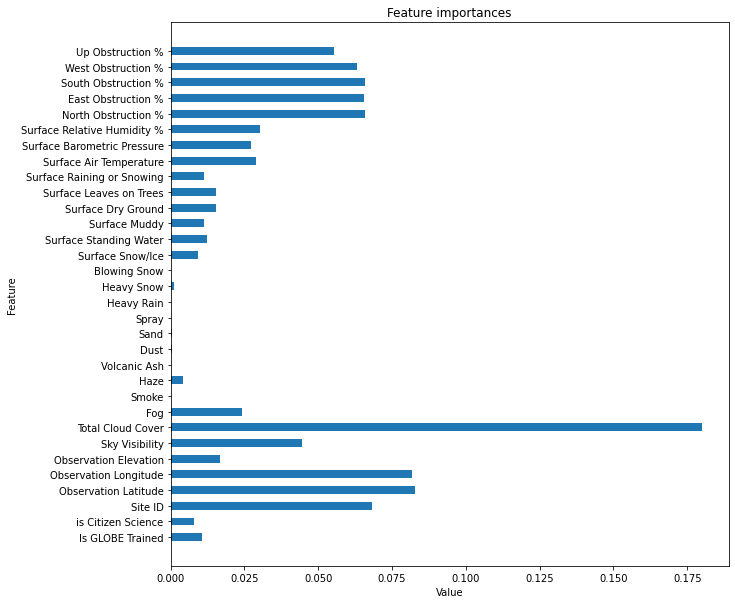

In [ ]:
plt.figure(figsize=(10, 10))
plt.barh(y=[f"{i}" for i in model.feature_names_in_], width=model.feature_importances_, height=0.5)
plt.title("Feature importances")
plt.ylabel("Feature")
plt.xlabel('Value')

In [ ]:
index = np.argsort(model.feature_importances_)
sorted_values = model.feature_importances_[index]
sorted_names = np.array([f"{i}" for i in model.feature_names_in_])[index]

Text(0.5, 0, 'Value')

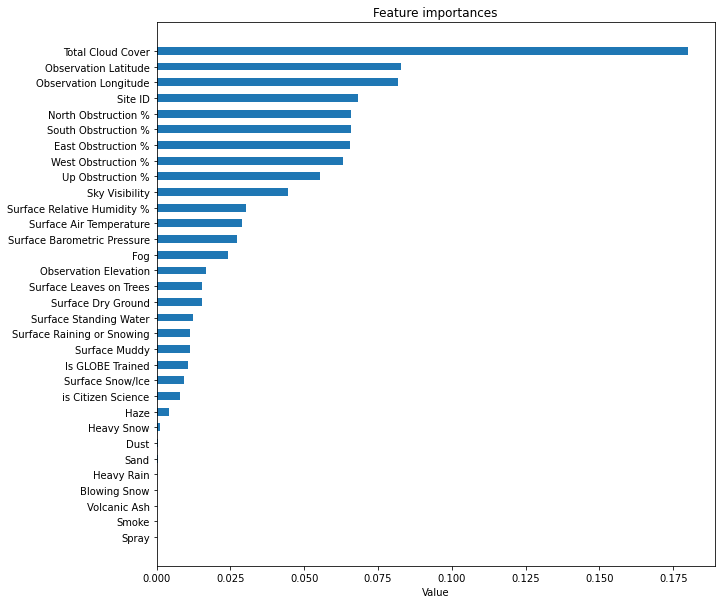

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.barh(y=sorted_names, width=sorted_values, height=0.5)
plt.title("Feature importances")
plt.xlabel('Value')

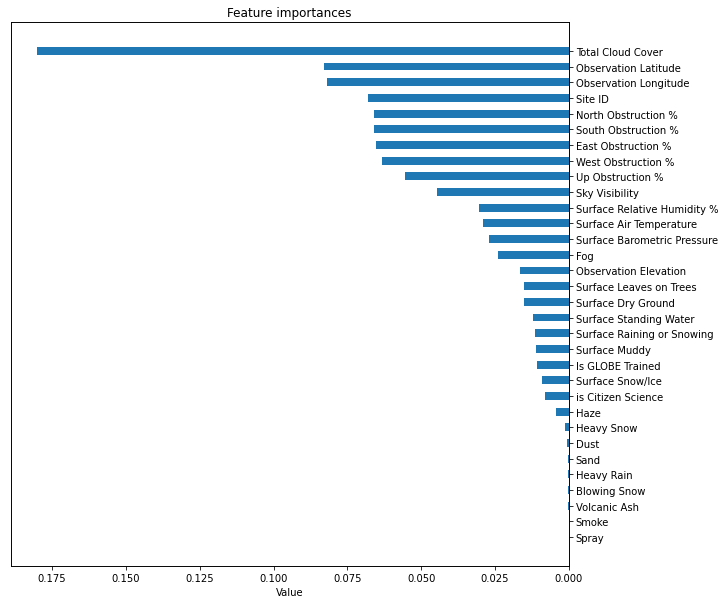

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

plt.title("Feature importances")
plt.xlabel('Value')
ax.invert_yaxis()  # labels read top-to-bottom
ax.invert_xaxis()  # labels read top-to-bottom

ax.set_yticklabels([]) # Hide the left y-axis tick-labels
ax.set_yticks([]) # Hide the left y-axis ticks
ax1 = ax.twinx() # Create a twin x-axis
ax1.barh(sorted_names, sorted_values, height=0.5) # Plot using `ax1` instead of `ax`

plt.show()

This is if you ran the code using one hot encoding. Notice that the number of features here (74) is different from the number of features in the training set (38). This is because of the one hot encoding done on the data during our preprocessing step.

Here we see how accuracy and hamming loss change depending on the different number of max depth (hyperparameter).

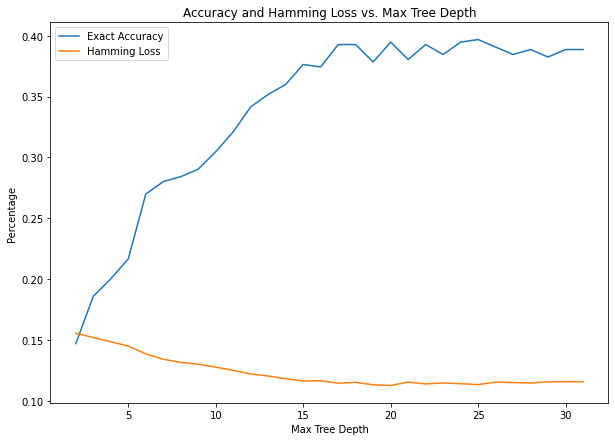

In [ ]:
acc = []
hamloss = []

for i in range(2,32,1):
  forest = RandomForestClassifier(max_depth=i, max_features=10, random_state=398)
  forest.fit(X_train, y_train)
  pred = forest.predict(X_test)
  acc.append(accuracy_score(y_test, pred))
  hamloss.append(hamming_loss(y_test, pred))

plt.figure(figsize=(10, 7))
plt.plot(range(2,32,1), acc, label = 'Exact Accuracy')
plt.plot(range(2,32,1), hamloss, label = 'Hamming Loss')
plt.title('Accuracy and Hamming Loss vs. Max Tree Depth')
plt.xlabel('Max Tree Depth')
plt.ylabel('Percentage')
plt.legend()
plt.show()

Here we see how accuracy and hamming loss change depending on the different number of max features (hyperparameter).

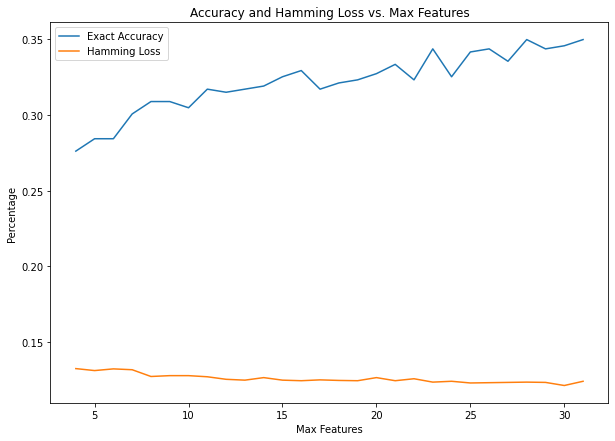

In [ ]:
acc = []
hamloss = []

for i in range(4,len(X_train.columns),1):
  forest = RandomForestClassifier(max_depth=10, max_features=i, random_state=398)
  forest.fit(X_train, y_train)
  pred = forest.predict(X_test)
  acc.append(accuracy_score(y_test, pred))
  hamloss.append(hamming_loss(y_test, pred))

plt.figure(figsize=(10, 7))
plt.plot(range(4,len(X_train.columns),1), acc, label = 'Exact Accuracy')
plt.plot(range(4,len(X_train.columns),1), hamloss, label = 'Hamming Loss')
plt.title('Accuracy and Hamming Loss vs. Max Features')
plt.xlabel('Max Features')
plt.ylabel('Percentage')
plt.legend()
plt.show()

## Are the Obstruction Ratios Really Correlated?

Train a model without the obstruction ratio data.

In [ ]:
# Drop the obsrtuction ratio rows
X2 = X.drop(labels=data.columns[[-1,-2,-3,-4,-5]], axis='columns', inplace=False)
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y, test_size=0.2, random_state=398)
model2 = RandomForestClassifier(max_depth=14, max_features='log2', random_state=398)
model2.fit(X_train2, y_train2)
y_pred_test2 = model2.predict(X_test2)
# View test accuracy score
print('Exact accuracy:', accuracy_score(y_test2, y_pred_test2), sep=' ')
print('Hamming Loss:', hamming_loss(y_test2, y_pred_test2), sep=' ')

Exact accuracy: 0.35787321063394684
Hamming Loss: 0.11991076408254323


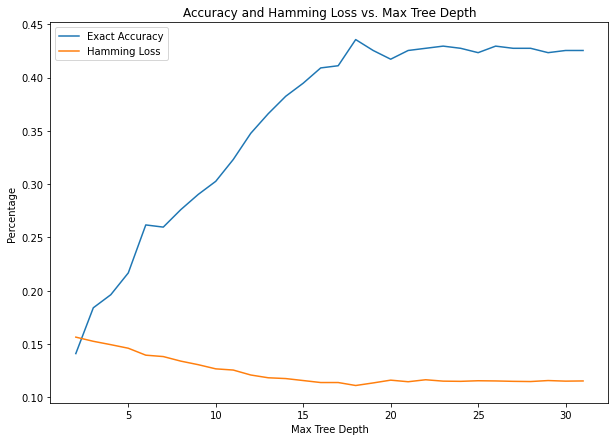

In [ ]:
acc = []
hamloss = []

for i in range(2,32,1):
  forest = RandomForestClassifier(max_depth=i, max_features=6, random_state=398)
  forest.fit(X_train2, y_train2)
  pred = forest.predict(X_test2)
  acc.append(accuracy_score(y_test2, pred))
  hamloss.append(hamming_loss(y_test2, pred))

plt.figure(figsize=(10, 7))
plt.plot(range(2,32,1), acc, label = 'Exact Accuracy')
plt.plot(range(2,32,1), hamloss, label = 'Hamming Loss')
plt.title('Accuracy and Hamming Loss vs. Max Tree Depth')
plt.xlabel('Max Tree Depth')
plt.ylabel('Percentage')
plt.legend()
plt.show()

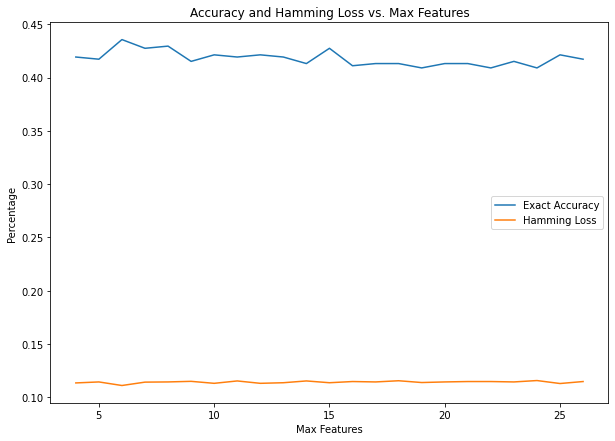

In [ ]:
acc = []
hamloss = []

for i in range(4,len(X_train2.columns),1):
  forest = RandomForestClassifier(max_depth=18, max_features=i, random_state=398)
  forest.fit(X_train2, y_train2)
  pred = forest.predict(X_test2)
  acc.append(accuracy_score(y_test2, pred))
  hamloss.append(hamming_loss(y_test2, pred))

plt.figure(figsize=(10, 7))
plt.plot(range(4,len(X_train2.columns),1), acc, label = 'Exact Accuracy')
plt.plot(range(4,len(X_train2.columns),1), hamloss, label = 'Hamming Loss')
plt.title('Accuracy and Hamming Loss vs. Max Features')
plt.xlabel('Max Features')
plt.ylabel('Percentage')
plt.legend()
plt.show()

In [ ]:
confusion_matrix_B2 = multilabel_confusion_matrix(y_true=y_test2, y_pred=y_pred_test2, samplewise=False)
confusion_matrix_B2

array([[[349,  26],
        [ 65,  49]],

       [[410,   8],
        [ 66,   5]],

       [[401,   6],
        [ 72,  10]],

       [[380,  20],
        [ 58,  31]],

       [[383,   9],
        [ 68,  29]],

       [[345,  14],
        [ 56,  74]],

       [[448,   4],
        [ 20,  17]],

       [[411,   8],
        [ 44,  26]],

       [[379,  11],
        [ 56,  43]],

       [[467,   1],
        [ 16,   5]],

       [[372,   2],
        [ 15, 100]]])

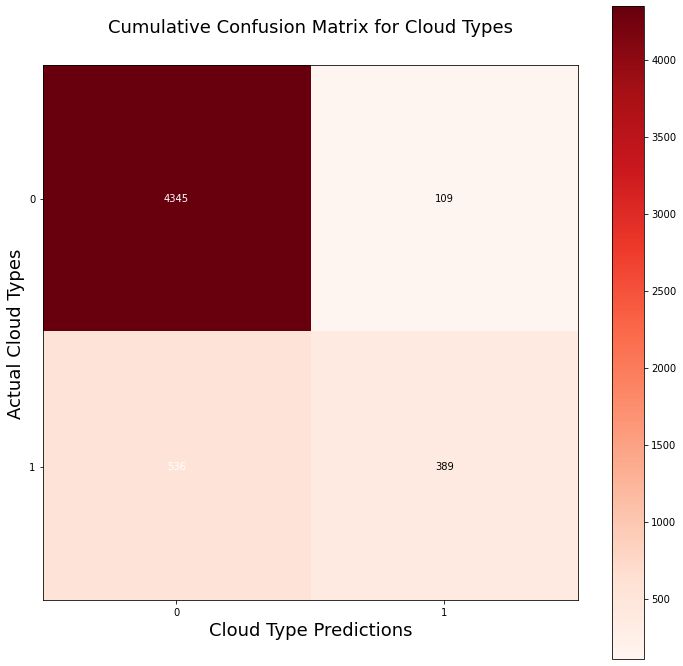

In [ ]:
fig, ax = plot_confusion_matrix(conf_mat=np.sum(confusion_matrix_B2, axis=0), figsize=(12, 12), cmap=plt.cm.Reds, colorbar=True)
plt.xlabel('Cloud Type Predictions', fontsize=18)
plt.ylabel('Actual Cloud Types', fontsize=18)
plt.title('Cumulative Confusion Matrix for Cloud Types', fontsize=18)
plt.show()